# Assignment: More Xarray with El Niño-Southern Oscillation (ENSO) Data

Here will will calculate the NINO 3.4 index of El Nino variabillity and use it to analyze datasets.

First read [this page from NOAA](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst). It tells you the following:

- The Niño 3.4 region is defined as the region between +/- 5 deg. lat, 170 W - 120 W lon.
- Warm or cold phases of the Oceanic Niño Index are defined by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above the threshold of +0.5°C (warm), or below the threshold of -0.5°C (cold). This is known as the Oceanic Niño Index (ONI).

(Note that "anomaly" means that the seasonal cycle, also called the "climatology" has been removed.)

Start by importing Numpy, Matplotlib, and Xarray. Set the default figure size to (12, 6).

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'

### 1. Reproduce the SST curve from the figure below

Use the `sst.mnmean.nc` file that we worked with in class, located at <http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc>.

You don't have to match the stylistic details, or use different colors above and below zero, just the "3mth running mean" curve.

![enso](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/eln-f-pg.gif)

Load the data as an Xarray dataset. Drop the `time_bnds` variable as we did in class and trim the data to 1950 onward for this assignment.

In [11]:
fname = '/data9/GR6901/data/sst.mnmean.nc'
data = xr.open_dataset(fname)
data = data.drop_vars('time_bnds').sst.sel(time = slice('1950', '2024'))

Now calculate the climatology and the SST anomaly.

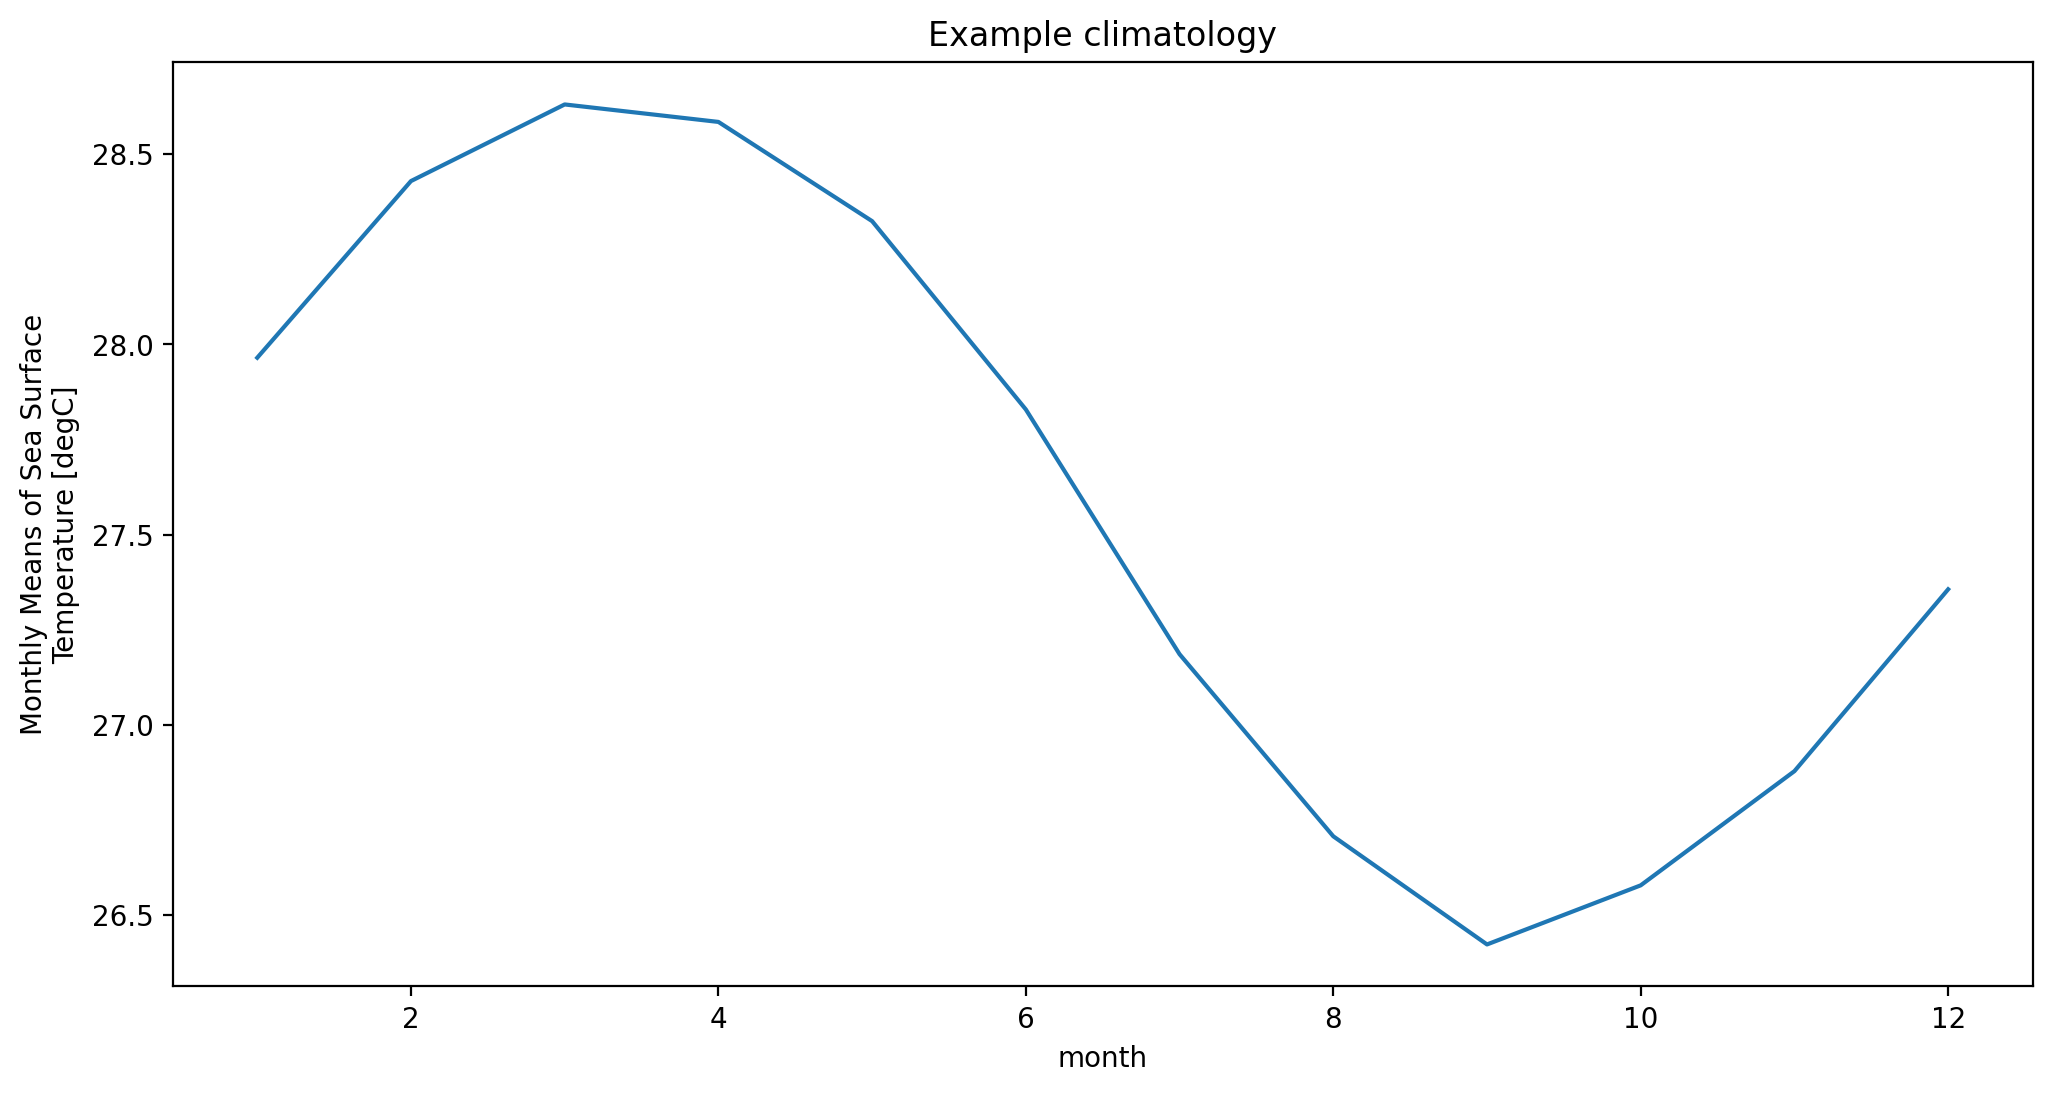

In [32]:
# calculating climatology
clim = data.groupby('time.month').mean(dim = 'time')

# plotting climatology for one random location
clim.isel(lat = 50, lon = 50).plot()
plt.title('Example climatology')
plt.show()

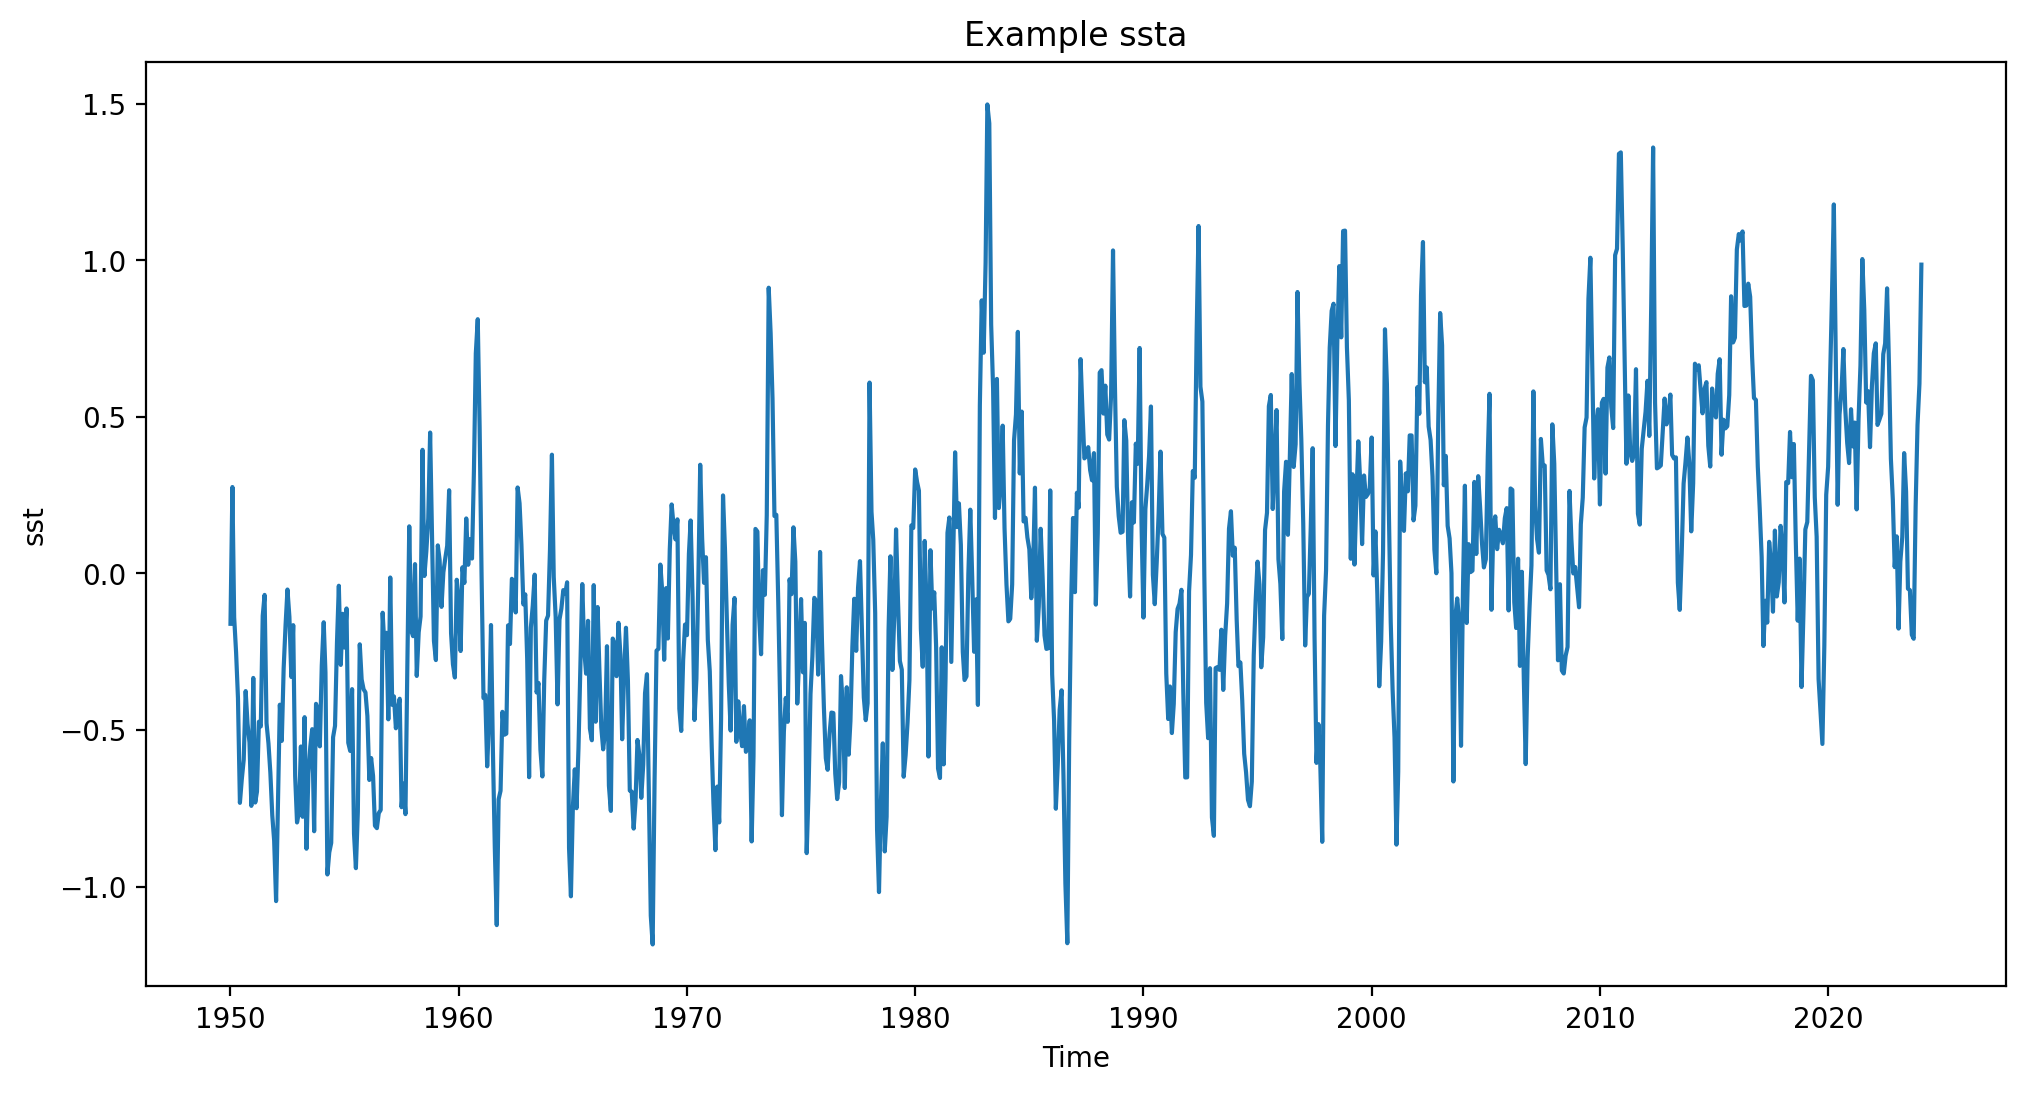

In [35]:
# calculating the sst anomaly
def RemoveTimeMean(x):
    return x - x.mean(dim = 'time')

ssta = data.groupby('time.month').apply(RemoveTimeMean)

# plotting an example of this
ssta.isel(lat = 50, lon = 50).plot()
plt.title('Example ssta')
plt.show()

Now reproduce the plot. Keep the rolling 3-month average of the SST anomaly as a DataArray for the next question.

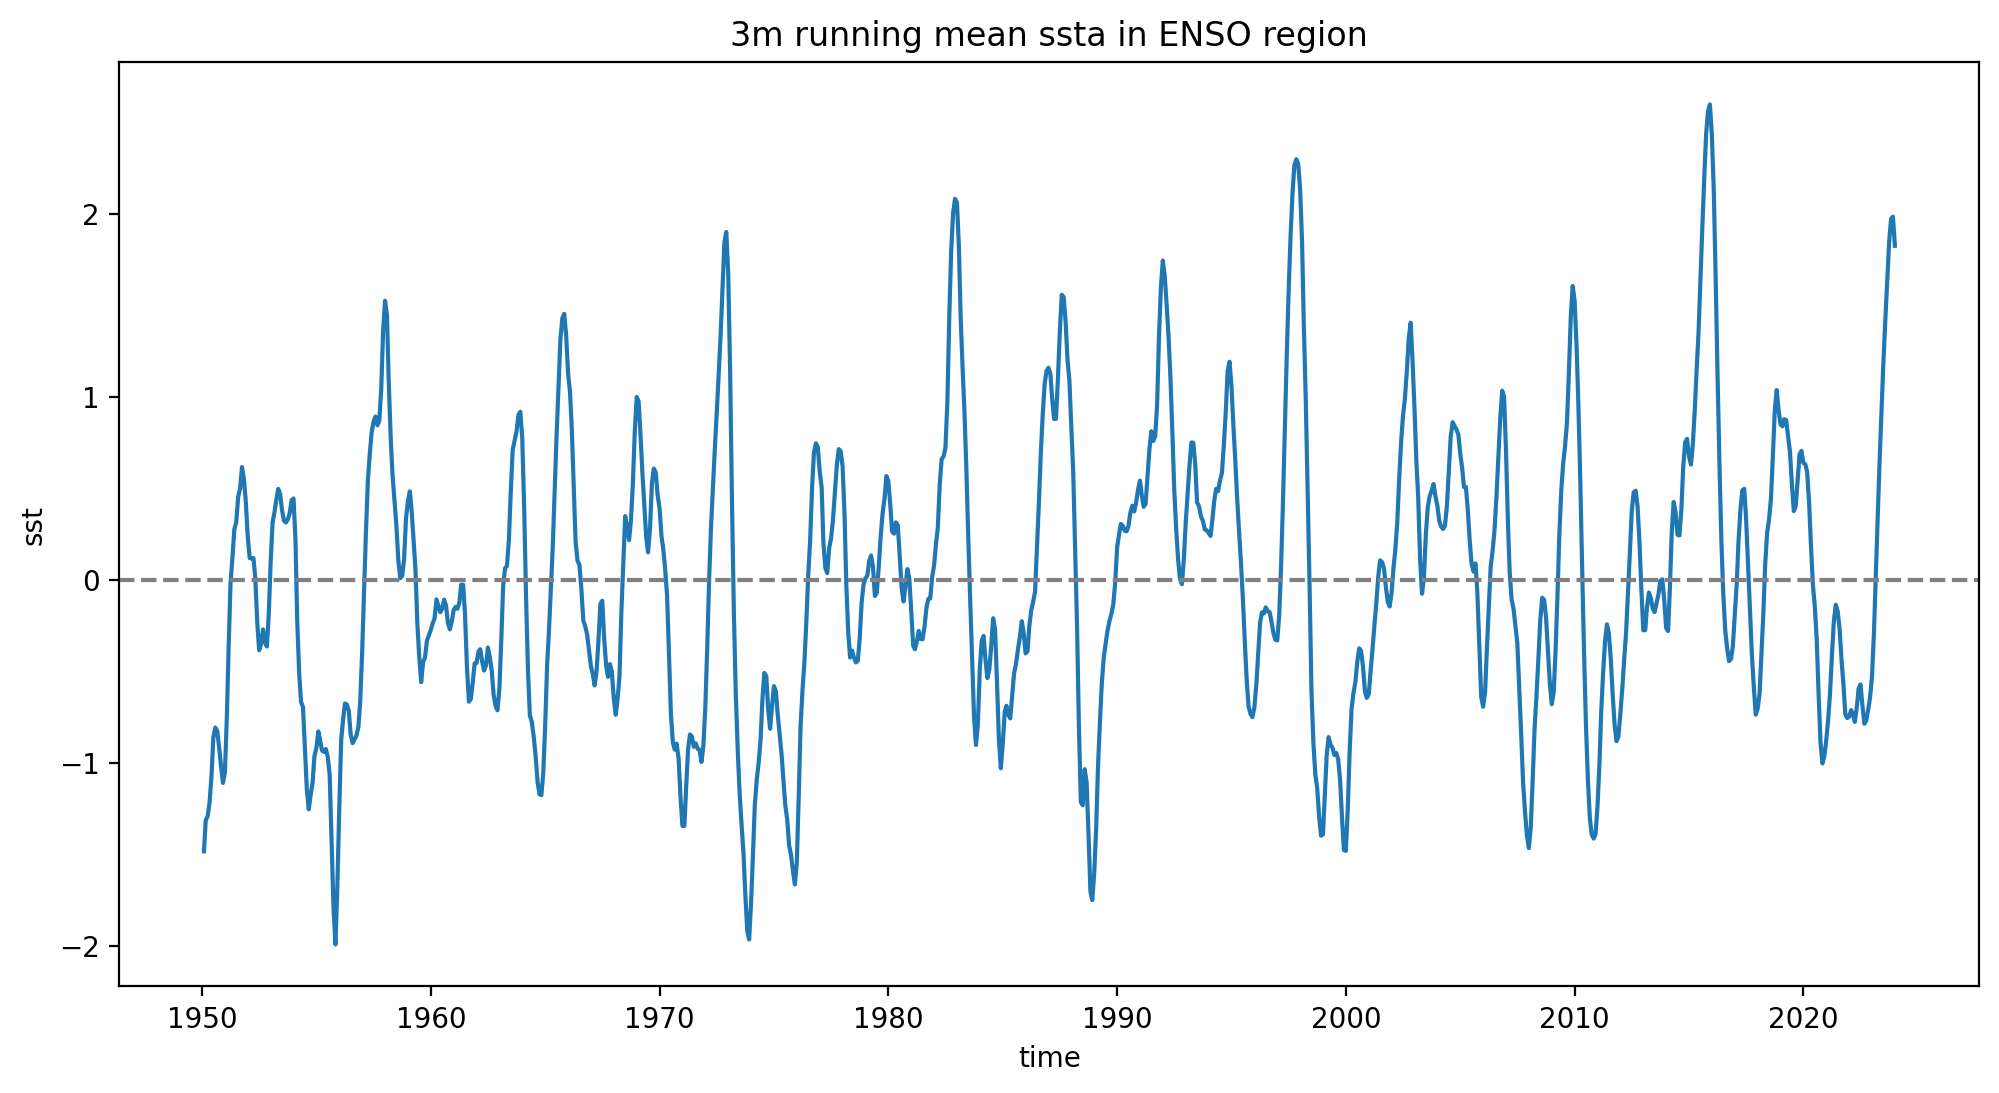

In [84]:
# defining the bounds for the box
latMin = -5
latMax = 5
lonMin = 360 - 170
lonMax = 360 - 120

# note that lat and lon may not be exact because the grid is 2x2, so we have to choose the nearest lat and lon in the dataset
latMinClose = data.lat.sel(lat = latMin, method = 'nearest')
latMaxClose = data.lat.sel(lat = latMax, method = 'nearest')
lonMinClose = data.lon.sel(lon = lonMin, method = 'nearest')
lonMaxClose = data.lon.sel(lon = lonMax, method = 'nearest')

# calculating the weighted average mean in this box
sstENSO = ssta.sel(lat = slice(latMaxClose, latMinClose), lon = slice(lonMinClose, lonMaxClose))
weights = np.cos(np.radians(sstENSO.lat))
sstENSOmean = sstENSO.weighted(weights).mean(dim = ('lat', 'lon'))

# just plotting the 3 month running mean per the question (i.e., not including the colouring)
sstaENSO3m = sstENSOmean.rolling(time = 3, center = True).mean()

# plotting this curve
sstaENSO3m.plot()
plt.axhline(y = 0, color = 'gray', linestyle = '--')
plt.title('3m running mean ssta in ENSO region')
plt.show()

### 2. Calculate boolean timeseries representing the positive / negative ENSO phases

Refer to the definitions of warm/cold phases above.

Warm or cold phases of the Oceanic Niño Index are defined by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above the threshold of +0.5°C (warm), or below the threshold of -0.5°C (cold). This is known as the Oceanic Niño Index (ONI).

In [164]:
thresholdVal = 0.5

# first find the values that fit the warm and cold phase definitions
anomPos = sstaENSO3m.where(sstaENSO3m >= thresholdVal)
anomNeg = sstaENSO3m.where(sstaENSO3m <= -thresholdVal)

indPos = [sstaENSO3m.values >= thresholdVal]
indNeg = [sstaENSO3m.values <= -thresholdVal]

# then check that they are consecutive
periods = 5
counter = 0
ONIpos = np.zeros(len(indPos[0]))

for i, ONI_index in enumerate(indPos[0]):
    if ONI_index == True:
        counter += 1
    if ONI_index == False:
        counter = 0
        ONIpos[i] = False

    if counter >= periods:
        ONIpos[i-counter+1: i+1] = True

counter = 0
ONIneg = np.zeros(len(indNeg[0]))

for i, ONI_index in enumerate(indNeg[0]):
    if ONI_index == True:
        counter += 1
    if ONI_index == False:
        counter = 0
        ONIneg[i] = False

    if counter >= periods:
        ONIneg[i-counter+1: i+1] = True

Plot them somehow.

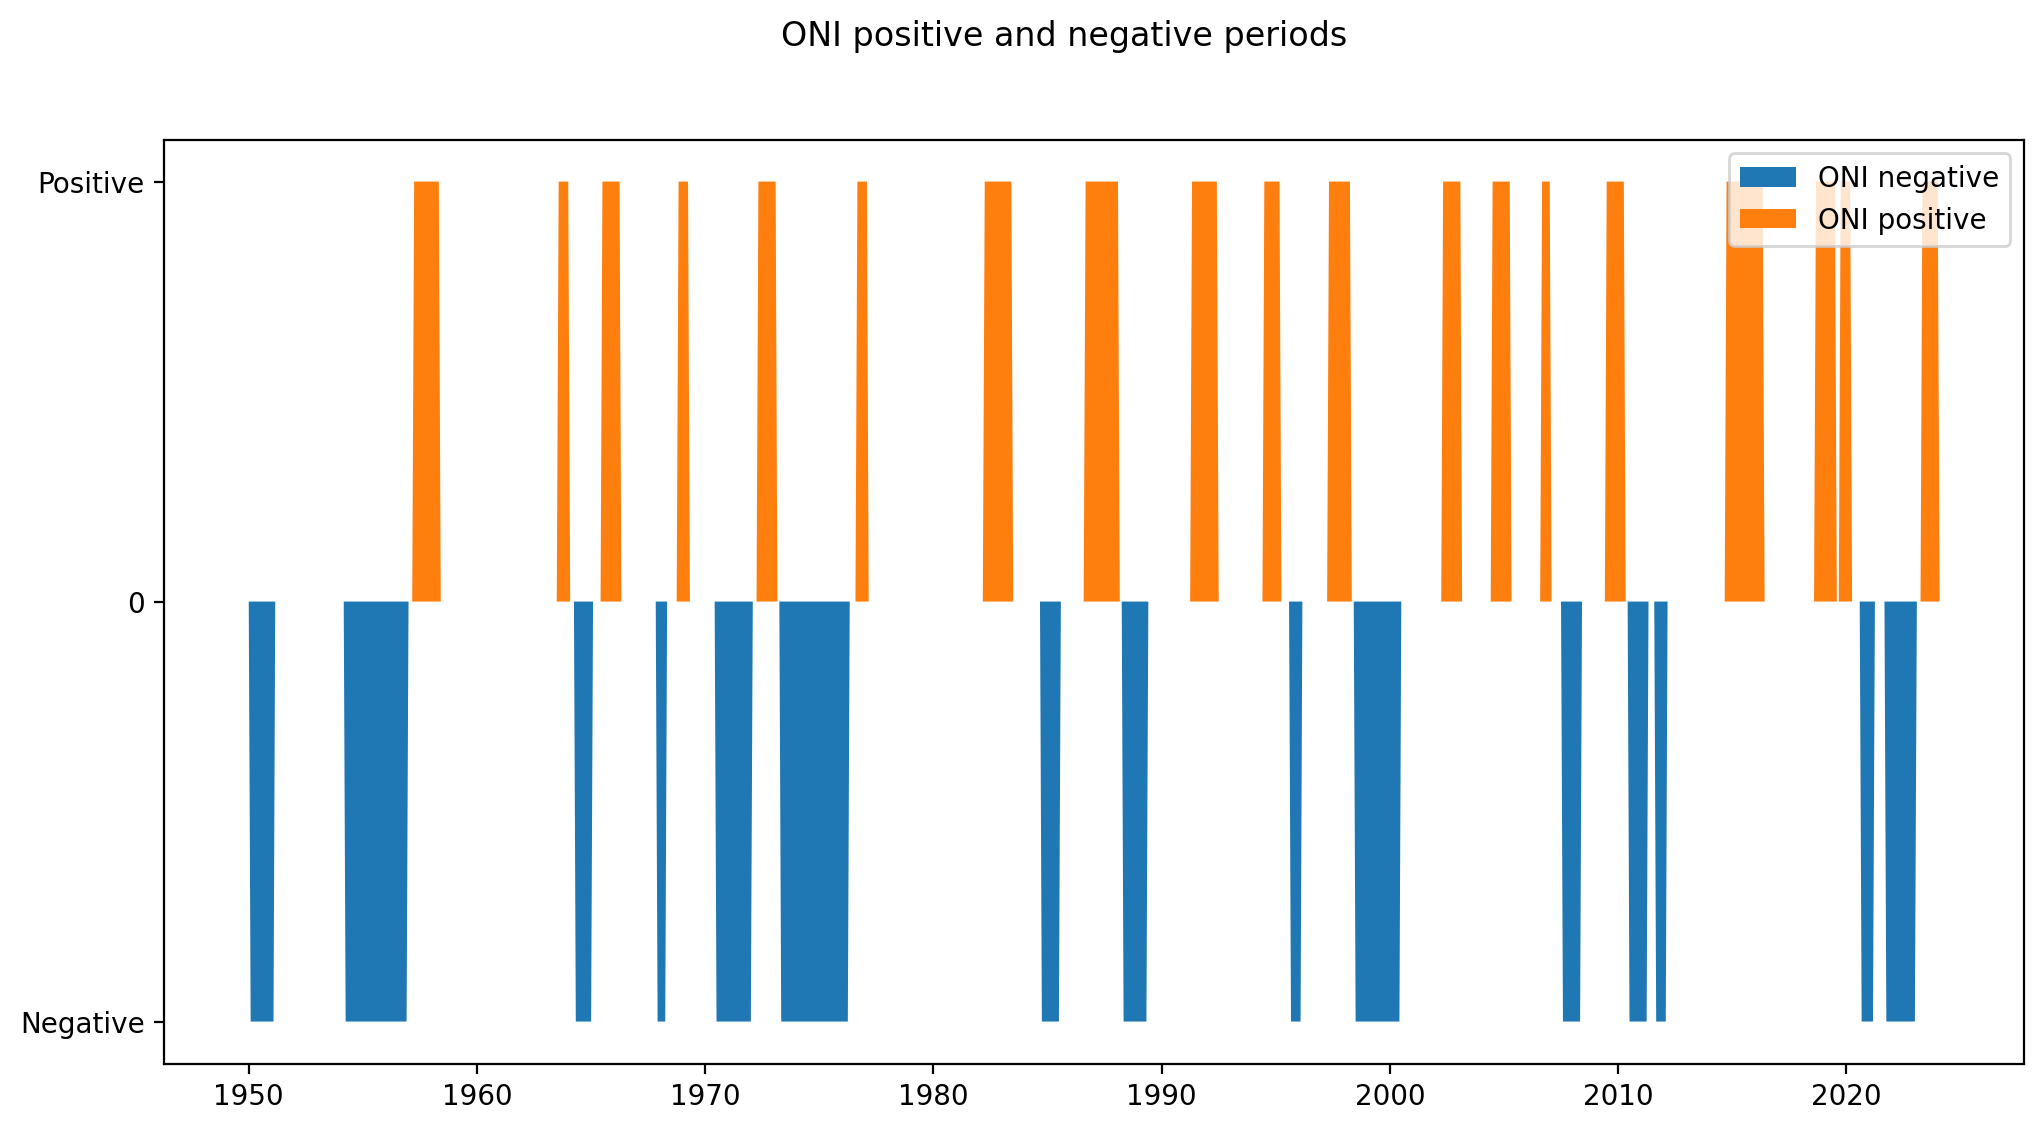

In [184]:
# note that based on the next question, I am assuming that this plot doesn't need to involve the ssta time series

fig, axes = plt.subplots()
fig.suptitle('ONI positive and negative periods')
plt.fill_between(sstaENSO3m.time, 0, -ONIneg, label = 'ONI negative')
plt.fill_between(sstaENSO3m.time, 0, ONIpos, label = 'ONI positive')
plt.yticks([1,0, -1], ['Positive', 0,  'Negative'])
plt.legend()
plt.show()

### 3. Plot composites of SST anomaly for the positive and negative ENSO regimes

These should be pcolormesh maps. First positive ONI.

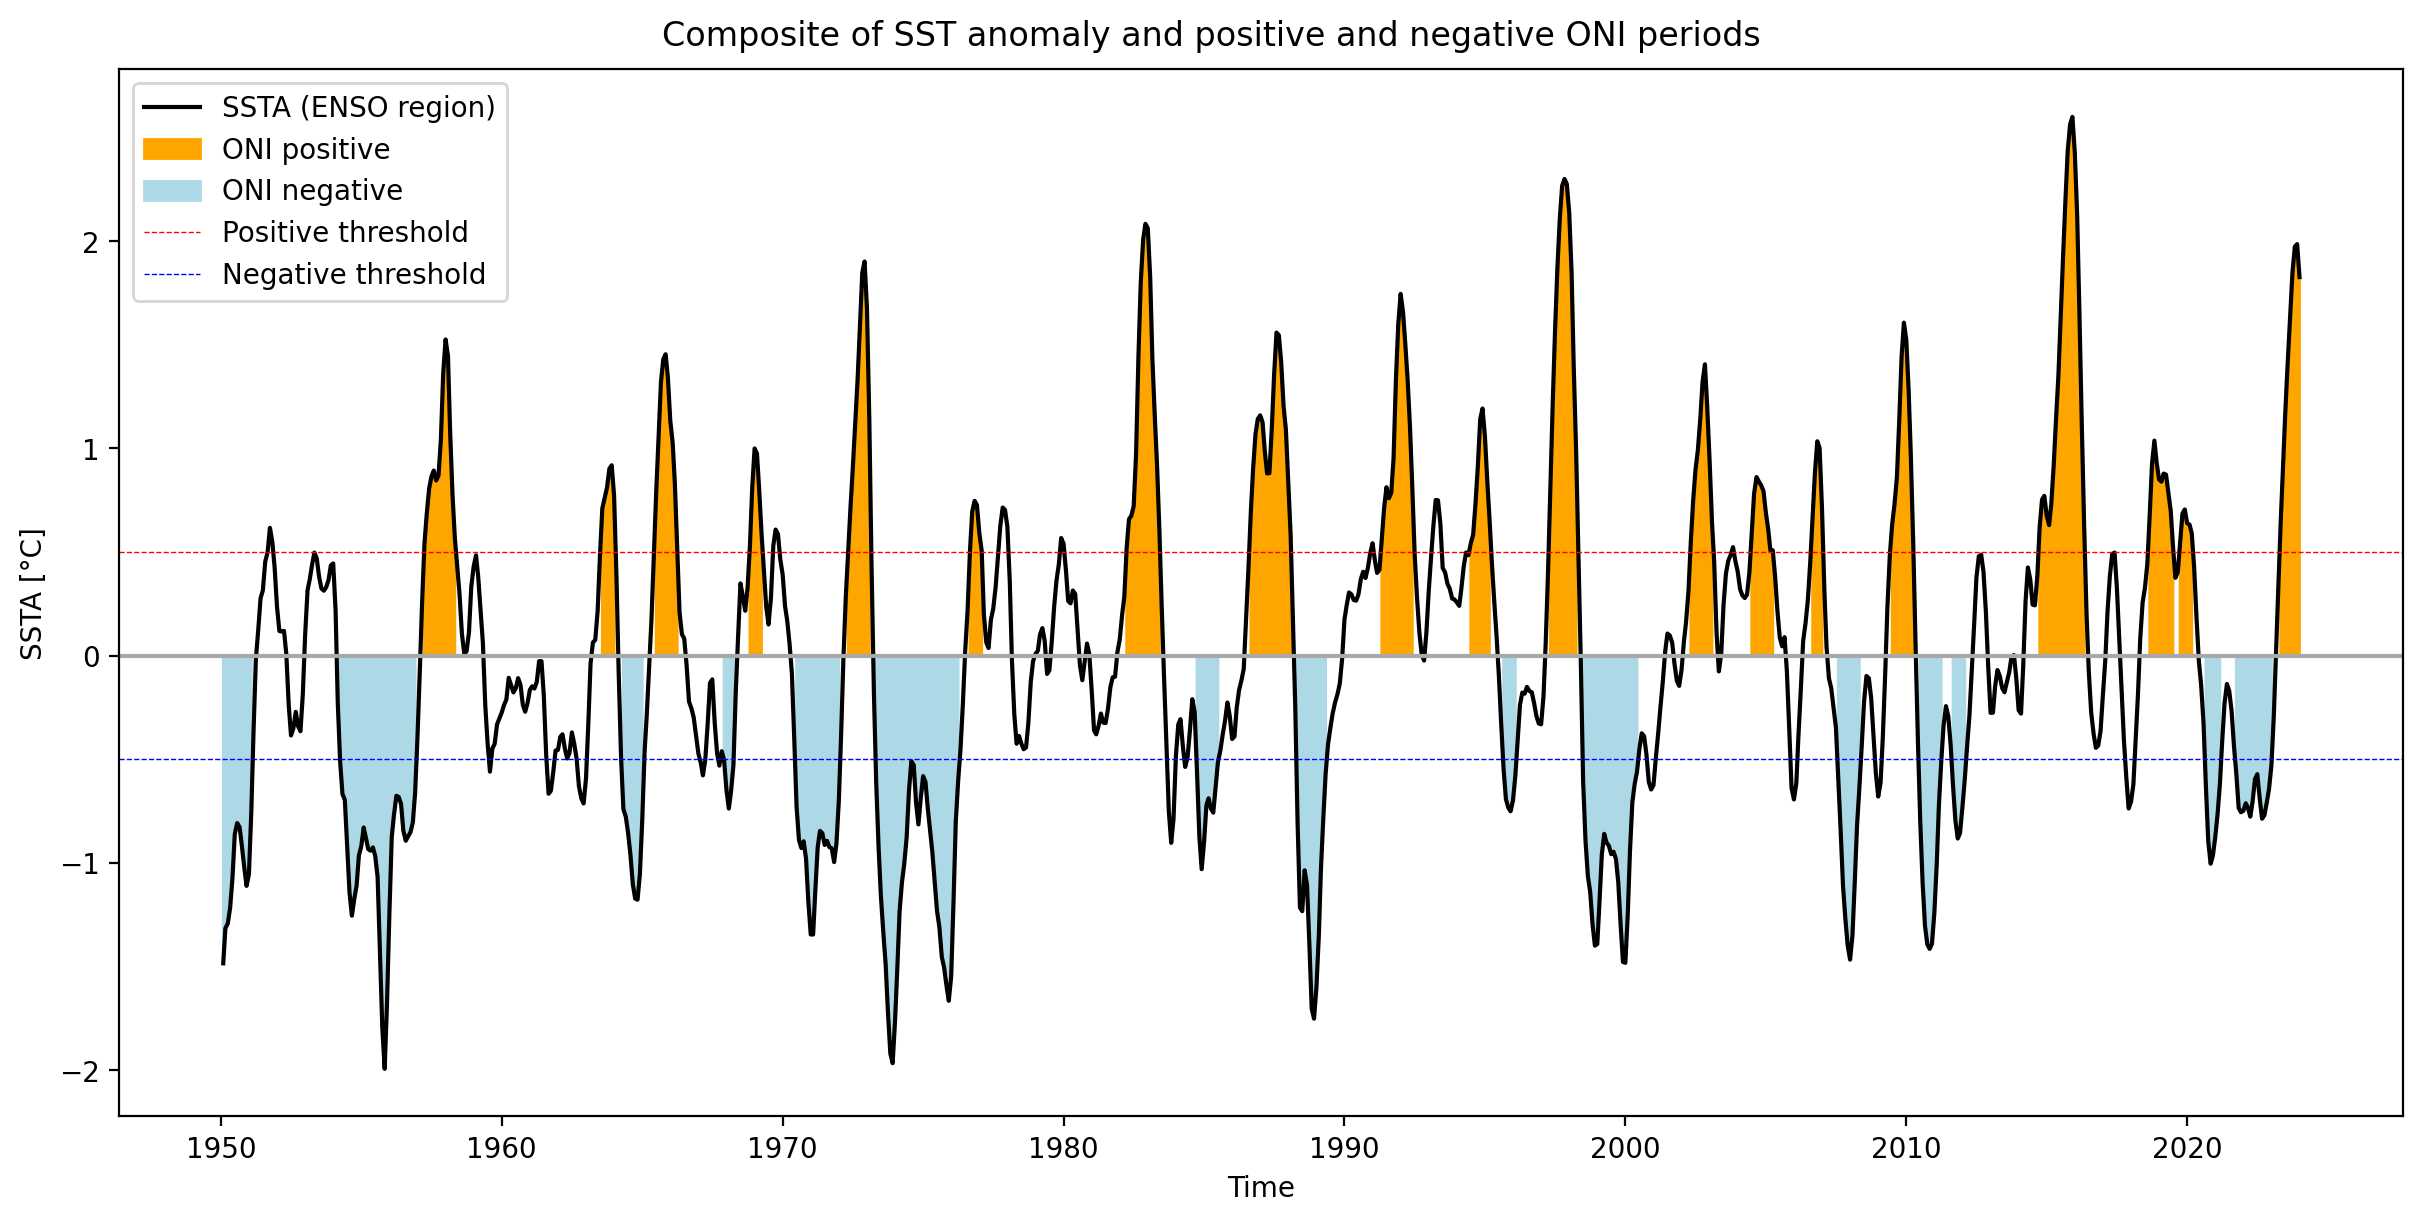

In [207]:
# note per my email I think that it would make more sense to plot this with fill_between

fig, axes = plt.subplots(constrained_layout = True)
fig.suptitle('Composite of SST anomaly and positive and negative ONI periods')

sstaENSO3m.plot(color = 'black', label = 'SSTA (ENSO region)')
plt.fill_between(sstaENSO3m.time, sstaENSO3m, where = ONIpos, color = 'orange', label = 'ONI positive')
plt.fill_between(sstaENSO3m.time, sstaENSO3m, where = -ONIneg, color = 'lightblue', label = 'ONI negative')

# including additional lines for reference
axes.axhline(y = 0, color = 'darkgray')
axes.axhline(y = thresholdVal, color = 'red', linewidth = 0.5, linestyle = '--', label = 'Positive threshold')
axes.axhline(y = -thresholdVal, color = 'blue', linewidth = 0.5, linestyle = '--', label = 'Negative threshold')

axes.set_ylabel('SSTA [°C]')
axes.set_xlabel('Time')
plt.legend()
plt.show()

And negative ONI.

### 4. Calculate the composite of preciptiation for positive and negative ENSO phases.

First load the precip dataset. Code to fix the broken time coordinate is included.

In [208]:
import pandas as pd
import xarray as xr
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V2p1/.multi-satellite/.prcp/dods'
dsp = xr.open_dataset(url, decode_times=False)
true_time = (pd.date_range(start='1960-01-01', periods=len(dsp['T']), freq='MS'))
dsp['T'] = true_time
dsp = dsp.rename({'T': 'time'})
dsp.load()

<xarray.Dataset>
Dimensions:  (time: 356, Y: 72, X: 144)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 1989-08-01
  * Y        (Y) float32 88.75 86.25 83.75 81.25 ... -81.25 -83.75 -86.25 -88.75
  * X        (X) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Data variables:
    prcp     (time, Y, X) float32 nan nan nan nan ... 0.6489 0.6437 0.636 0.6303
Attributes:
    Conventions:  IRIDL

Now plot the *difference* between the time-mean of `prcp` during positive and negative ENSO phases.

In [237]:
# calculate the time mean of prcp during 1) positive and 2) negative ENSO phases

# first have to get the prcp data to be the same shape as the ONI index data | note that the precip data only goes to 1989 (august)
# for this, I will turn the ONI arrays into xarrays so that we can adjust the time accordingly

ONIposda = xr.DataArray(ONIpos,
                        dims = 'time', 
                        coords = {'time': sstaENSO3m.time})

ONInegda = xr.DataArray(ONIneg,
                        dims = 'time', 
                        coords = {'time': sstaENSO3m.time})

# trimming these two datasets to the right length for the precipitation data
ONIposda = ONIposda.sel(time = slice(dsp.time[0], dsp.time[-1]))
ONInegda = ONInegda.sel(time = slice(dsp.time[0], dsp.time[-1]))

# now calculating the time mean during positive and negative phases
precipPosMean = dsp.prcp.where(ONIposda).mean(dim = 'time')
precipNegMean = dsp.prcp.where(ONInegda).mean(dim = 'time')

# now calculate the difference between them
precipDiff = precipPosMean - precipNegMean

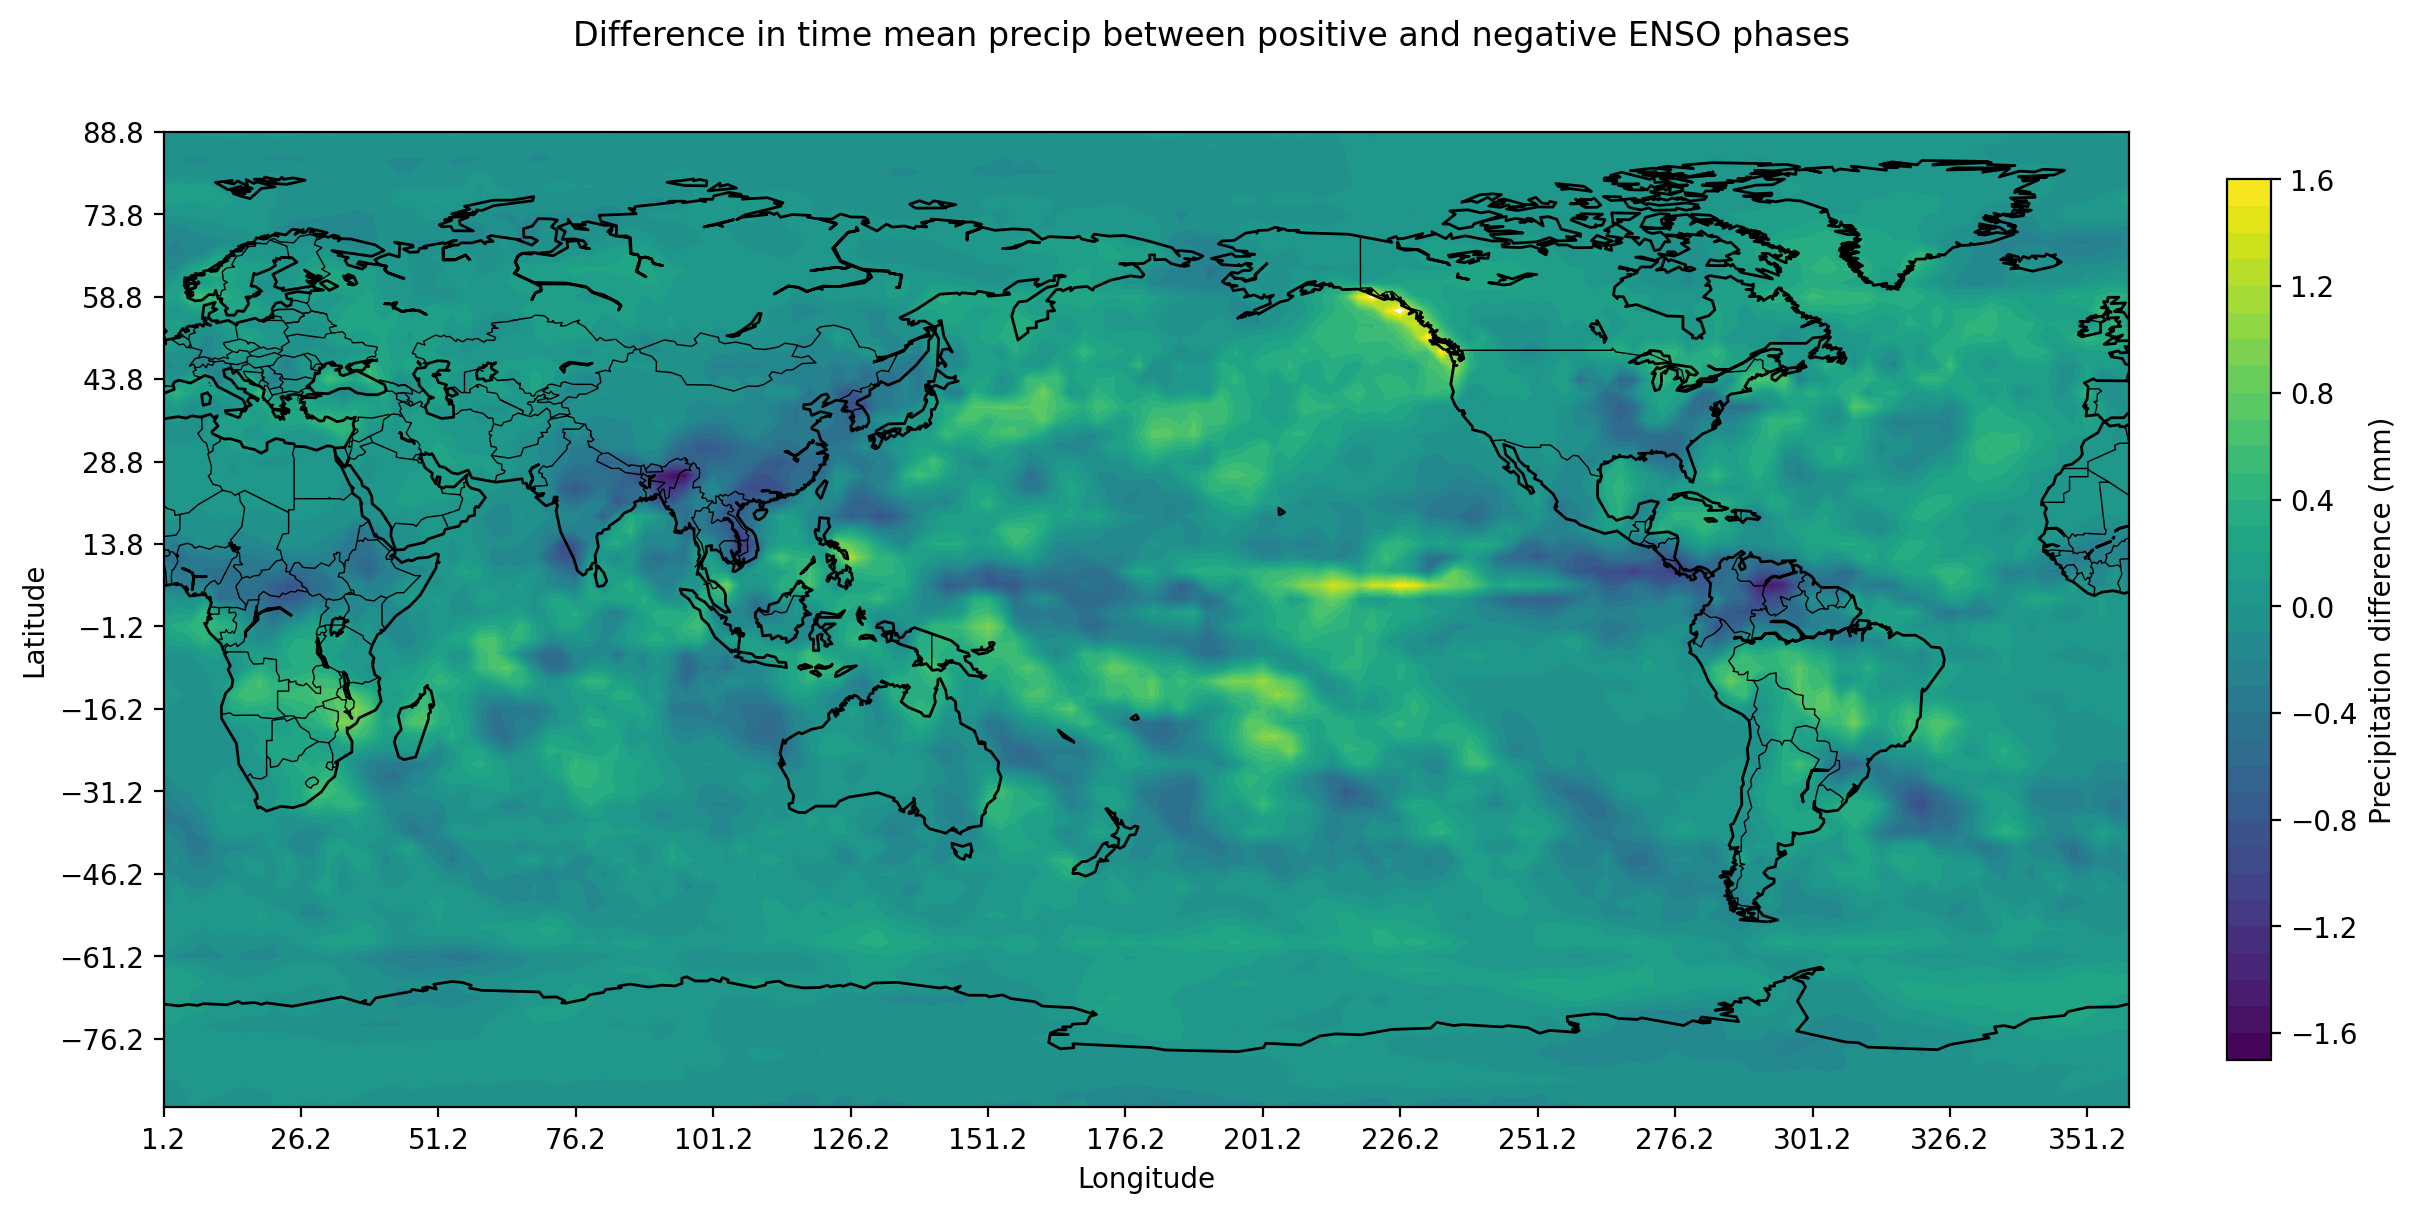

In [292]:
# trying to plot this with a map
from mpl_toolkits.basemap import Basemap

fig = plt.figure(constrained_layout = True)
fig.suptitle('Difference in time mean precip between positive and negative ENSO phases')

map = Basemap(llcrnrlat = dsp.Y[-1], llcrnrlon = dsp.X[0], urcrnrlat = dsp.Y[0], urcrnrlon = dsp.X[-1])
clevels = np.arange(-1.7,1.7,0.1)
plt.contourf(precipDiff.X, precipDiff.Y, precipDiff, clevels, cmap = 'viridis')
map.drawcoastlines()
map.drawcountries()

plt.yticks(precipDiff.Y[np.arange(0,len(precipDiff.Y), 6)])
plt.xticks(precipDiff.X[np.arange(0,len(precipDiff.X), 10)])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.colorbar(shrink = 0.8, label = 'Precipitation difference (mm)')
plt.show()